# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

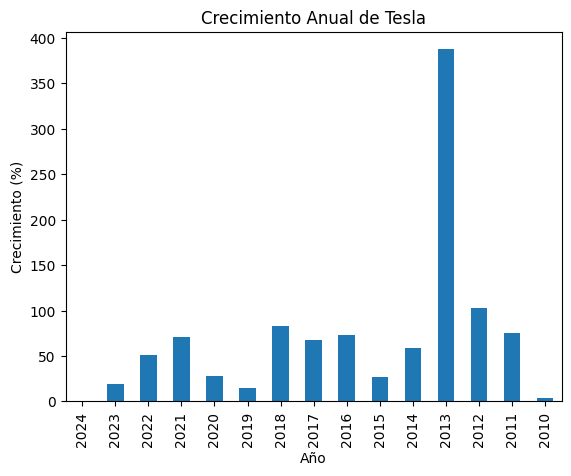

In [7]:
from bs4 import BeautifulSoup
import requests
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO

# Paso 2: Descargar HTML
url = 'https://companies-market-cap-copy.vercel.app/index.html'
response = requests.get(url)

if response.status_code == 200:
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')

    # Buscar todas las tablas
    tables = soup.find_all('table')
    if not tables:
        print("No se encontraron tablas en el HTML.")
    else:
        annual_growth_table = tables[0]
        html_string = str(annual_growth_table)
        df = pd.read_html(StringIO(html_string))[0]

        # Limpiar datos y convertir columnas a tipos numéricos
        df['Revenue'] = df['Revenue'].replace({"[$B]": ""}, regex=True).str.strip().astype(float)
        df['Change'] = df['Change'].replace({"%": ""}, regex=True).str.strip().astype(float)
        df.dropna(subset=['Year', 'Revenue', 'Change'], inplace=True)

        # Crear una conexión a la base de datos con tiempo de espera
        with sqlite3.connect('tesla_growth.db', timeout=10) as conn:
            c = conn.cursor()
            c.execute('DROP TABLE IF EXISTS tesla_growth')
            c.execute('''
            CREATE TABLE tesla_growth (
                Year INTEGER,
                Revenue FLOAT,
                Change FLOAT
            )
            ''')
            for index, row in df.iterrows():
                c.execute('''
                INSERT INTO tesla_growth (Year, Revenue, Change) 
                VALUES (?, ?, ?)
                ''', (row['Year'], row['Revenue'], row['Change']))
            conn.commit()

        # Gráfico de barras
        df.plot(kind='bar', x='Year', y='Change', legend=False)
        plt.title('Crecimiento Anual de Tesla')
        plt.xlabel('Año')
        plt.ylabel('Crecimiento (%)')
        plt.show()

else:
    print(f"F en el chat. Código de error: {response.status_code}")

